In [1]:
from sklearn.decomposition import PCA
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import datetime as dt
import datetime

def obs_range(pre_entry_bars):
    high = pre_entry_bars.high.max()
    low = pre_entry_bars.low.min()
    return (high - low)

def obs_dis_from_mid_pt(pre_entry_bars):
    high = pre_entry_bars.high.max()
    low = pre_entry_bars.low.min()
    return ((pre_entry_bars.close.iloc[-1]-low)/(high-low)) - 0.5

def obs_abs_return(pre_entry_bars):
    return abs(pre_entry_bars.close.iloc[-1] - pre_entry_bars.open.iloc[0])

def obs_return(pre_entry_bars):
    return (pre_entry_bars.close.iloc[-1] - pre_entry_bars.open.iloc[0])

In [2]:
### This is the cell for reading the csvs
# The first line is for loading the larger dataset
# the second line which I commented out is for the two closest weeks that we tested
# last time


sf = pd.read_csv('USD_CNH_BID.csv')
# sf = pd.read_csv('TRUTH/USD_CNH_BID.csv',parse_dates = [0])

candles = pd.read_csv('fixed_HSI2Y.csv', parse_dates=['datetime'])
# candles = pd.read_csv('TRUTH/THE_TRUTH.csv', parse_dates=['datetime'])

technical = pd.read_csv('daily_technicals.csv', parse_dates=[0])
# technical = pd.read_csv('TRUTH/daily_technicals.csv', parse_dates=[0])

In [3]:
# This is the code for getting the dataframe, ideally you just have
# to run it once in your analysis, since it takes a while
# note that it is for 80, 20 position prediction



sf.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)

sf = sf.sort_values('Time')

sf['Time'] = sf['Time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# sf = sf[sf.Time >= '2017-01-01']


# check na
# sf.isnull().values.sum()

trigger_time = datetime.time(9,45)

sf['No_date'] = sf['Time'].apply(lambda x: True if (x.time() >= datetime.time(6,30)) and 
                                   (x.time() <= trigger_time) else False)

ssf = pd.DataFrame(sf[list(sf['No_date'])], index=None).reset_index(drop=True)

for i in range(1,13):
    ssf['%i min open return' %(i*5)] = float('nan')

for j in range(1,13):
    row_iterator = ssf.iterrows()
    _, last = next(row_iterator)
    
    for i, row in row_iterator:
        if row['Time'].time() == (datetime.datetime.strptime('{:%H:%M}'.format(trigger_time), '%H:%M') - datetime.timedelta(minutes = 5*(j-1))).time():
            ssf.loc[i+j-1, '%i min open return' %(j*5)] = (row['open'] - last['open'])/last['open']*100
        last = row

for i in range(1,7):
    ssf['%i half hour open return' %(i)] = float('nan')

for j in range(1,7):
    row_iterator = ssf.iterrows()
    _, last = next(row_iterator)
    
    for i, row in row_iterator:
        if row['Time'].time() == (datetime.datetime.strptime('{:%H:%M}'.format(trigger_time), '%H:%M') - datetime.timedelta(minutes = 30*(j-1))).time():
            ssf.loc[i+(j-1)*6, '%i half hour open return' %(j)] = (ssf.loc[i, 'open']- ssf.loc[i-6, 'open'])/ssf.loc[i-6, 'open']*100

ssf.dropna(inplace=True)
ssf.reset_index(inplace=True)
# ssf.to_csv('CNH_USD_BID_CHANGE_9:45.csv')

variables=[obs_abs_return,obs_dis_from_mid_pt,obs_range,obs_return]
variables_table = []


#read input of market and their time
pre_market_open = dt.datetime.strptime('09:15', '%H:%M')
market_open = dt.datetime.strptime('09:30' , '%H:%M')
market_close = dt.datetime.strptime('16:30' , '%H:%M')
entry_time = dt.datetime.strptime('09:45' , '%H:%M')

#identifying start date and end date as well as let us to get access of the date
candle_timestamps = set(candles.datetime)
candles['date'] = candles.datetime.map(lambda x: x.date())
candles['time'] = candles.datetime.map(lambda x: x.time())
start = candles.date.min()
end = candles.date.max()
date_count = (end - start).days + 1
market_open_length = int((market_close - market_open).seconds/60)
market_observe_length = int((entry_time - pre_market_open).seconds/60)


marketdays = []

for date in (start + dt.timedelta(n) for n in range(date_count)):
    #check if it is a full day market or not
    if not(pd.Timestamp(dt.datetime.combine(date,(market_open).time())) in candle_timestamps):
        candles = candles[(candles.datetime < dt.datetime.combine(date, dt.time(9,15))) | (candles.datetime >= dt.datetime.combine(date + dt.timedelta(days = 1), dt.time(0,55)))]
        continue
    if not(dt.datetime.combine(date, (market_close + dt.timedelta(minutes = -5)).time()) in candle_timestamps):
        candles = candles[(candles.datetime < dt.datetime.combine(date, dt.time(9,15))) | (candles.datetime >= dt.datetime.combine(date + dt.timedelta(days = 1), dt.time(0,55)))]
        continue
    marketdays.append(date)

yes_after_market_bars = []
pre_market_bars = []
pre_entry_bars = []
post_entry_bars = []
entry_to_lunch_bars = []

for i in range(1,len(marketdays)):
    #classify the candles of the day into pre entry and post entry
    after_market_start = dt.datetime.combine(marketdays[i-1], market_close.time())
    pre_market_start = dt.datetime.combine(marketdays[i], dt.time(9,15))
    pre_entry_start = dt.datetime.combine(marketdays[i], market_open.time())
    pre_entry_end = dt.datetime.combine(marketdays[i], entry_time.time())
    post_entry_end = dt.datetime.combine(marketdays[i], market_close.time())
    lunch_time = dt.datetime.combine(marketdays[i], dt.time(10,0))
    
    yes_after_market = (candles.datetime >= after_market_start) & (candles.datetime < pre_market_start)
    pre_market = (candles.datetime >= pre_market_start) & (candles.datetime < pre_entry_start)
    pre_entry = (candles.datetime >= pre_entry_start) & (candles.datetime < pre_entry_end)
    entry_to_lunch = ((candles.datetime >= pre_entry_end) & (candles.datetime < lunch_time))
    post_entry = (candles.datetime >= pre_entry_end) & (candles.datetime < post_entry_end)
    
    yes_after_market_bars.append(candles[yes_after_market])
    pre_market_bars.append(candles[pre_market])
    pre_entry_bars.append(candles[pre_entry])
    post_entry_bars.append(candles[post_entry])
    entry_to_lunch_bars.append(candles[entry_to_lunch])

data_table = pd.DataFrame(index = marketdays[1:])

obs_return = []
obs_range = []
obs_dis_from_mid_pt = []
obs_agg_volume = []
obs_fh_volume = []
obs_fh_return = []
obs_afterhr_return = []
obs_open_market_gap = []


for i in range(len(marketdays)-1):
    high = pre_entry_bars[i].high.max()
    low = pre_entry_bars[i].low.min()
    
    obs_return.append(pre_entry_bars[i].close.iloc[-1] - pre_entry_bars[i].open.iloc[0])
    obs_range.append(high-low)
    obs_dis_from_mid_pt.append((pre_entry_bars[i].close.iloc[-1]-low)/(high-low) - 0.5)
    obs_agg_volume.append(sum(pre_entry_bars[i].volume))
#     obs_fh_volume.append(sum(pre_entry_bars[i].volume.iloc[:12]))
#     obs_fh_return.append(pre_entry_bars[i].close.iloc[11] - pre_entry_bars[i].open.iloc[0])
    
    if len(yes_after_market_bars[i]) == 0 or len(pre_market_bars[i]) == 0:
        obs_afterhr_return.append(None)
        obs_open_market_gap.append(None)
    else:
        obs_afterhr_return.append(yes_after_market_bars[i].close.iloc[-1] - yes_after_market_bars[i].open.iloc[0])
        obs_open_market_gap.append(pre_market_bars[i].open.iloc[0] - yes_after_market_bars[i].close.iloc[-1])
    
    

data_table['return'] = obs_return
data_table['range'] = obs_range
data_table['dis_from_mid_pt'] = obs_dis_from_mid_pt
data_table['agg_volume'] = obs_agg_volume
# data_table['fh_volume'] = obs_fh_volume
# data_table['fh_return'] = obs_fh_return
data_table['afterhr_return'] = obs_afterhr_return
data_table['open_market_gap'] = obs_open_market_gap

pseudo_time = dt.datetime(1996,1,1,hour = 9,minute = 15)
for i in ((pseudo_time + dt.timedelta(minutes = n)).time() for n in range(0,int(market_observe_length),5)):
    marketday_indexframe = pd.DataFrame(index = marketdays[1:])
    specific_time_bars = candles[candles.time == i]
    if len(specific_time_bars) < 0.9 * (len(marketdays)-1):
        continue
    date_indexed_bars = specific_time_bars[1:].set_index('date')
    date_indexed_bars['return'] = date_indexed_bars.close - date_indexed_bars.open
    date_indexed_vol_bars = date_indexed_bars['volume']
    date_indexed_return_bars = date_indexed_bars['return']
    
    vol_by_time = pd.concat([marketday_indexframe,date_indexed_vol_bars], axis = 1, sort = False)
    return_by_time = pd.concat([marketday_indexframe,date_indexed_return_bars], axis = 1, sort = False)
    
    data_table[f'return_{i}'] = return_by_time
    data_table[f'volume_{i}'] = vol_by_time
    
results = []  
for i in entry_to_lunch_bars:
    benchmark = i.iloc[0].open
    rank_ptc = sum(i.open < benchmark)/(len(i) -1)-0.5
    results.append(rank_ptc)

# print(len(results))
# print(data_table)

# fix technical

technical.Date = technical.Date.apply(lambda x: x.date())
technical = technical[np.where(technical.Date == data_table.index[0])[0][0]:np.where(technical.Date == data_table.index[-1])[0][0]+1]

mismatch = []
for i in technical.index:
    if technical.Date[i] not in data_table.index:
        mismatch.append(i)
        
technical = technical.drop(mismatch, axis=0)

technical = technical.reset_index(drop=True)
technical = technical.set_index('Date')

# fix ssf

ssf = ssf.drop('index', axis=1)

ssf.Time = ssf.Time.apply(lambda x: x.date())
mismatch = []
for i in ssf.index:
    if ssf.Time[i] not in data_table.index:
        mismatch.append(i)

ssf = ssf.drop(mismatch, axis=0)

ssf = ssf.set_index('Time')

df = pd.concat([data_table, technical], axis=1)

mismatch = []
mismatch_y = []
for i in data_table.index:
    if i not in list(ssf.index):
        mismatch.append(i)
        mismatch_y.append(list(data_table.index).index(i))
        
y  = results
y = pd.DataFrame(data = {'rel posi': y})
y = y.drop(mismatch_y, axis=0)
df = df.drop(mismatch, axis=0)

ssf = ssf.sort_index()

df = pd.concat([df, ssf], axis=1)

# check na
# list(np.where(sum(df.isnull().T.values) != 0)[0])

# drop na in both df and y
y = y.drop(list(np.where(sum(df.isnull().T.values) != 0)[0]))
df.dropna(axis=0, inplace=True)

df = df.reindex(sorted(df.columns), axis=1)

# relative to open is what percentage
# smaller the number is, the lower it is in position relative to the coming bars in the smae market day
# now scale to 1, so if 1, that means that the opening is the highest bar you could have in that day
y = y + 0.5
y = y*100

# this is the putting y as a np array for the following ML training
y = np.array(y['rel posi'])

for i in range(len(y)):
    if y[i] >= 80:
        y[i] = 2
    elif y[i] <= 20:
        y[i] = 0
    else:
        y[i] = 1

## The data are in df, the response in y

In [4]:
# since there are 477 datapoint, if say you want to get the 250 to 300 data points

data_set = df.iloc[250:300, :]
response = y[250:300]

In [5]:
# this is where I droped extra variables, I dropped everything from the 50
# variable onward, you may change this if you want

data_set = data_set.drop(data_set.columns[50:], axis=1)

In [6]:
data_set

,1 half hour open return,10 min open return,15 min open return,2 half hour open return,20 min open return,25 min open return,3 half hour open return,30 min open return,35 min open return,4 half hour open return,...,resistance[3],resistance[4],resistance[5],return,return_09:15:00,return_09:20:00,return_09:25:00,return_09:30:00,return_09:35:00,return_09:40:00
2017-11-14,-0.045124,-0.010983,-0.016847,-0.045705,-0.002708,0.013088,-0.031713,-0.016245,-0.010678,-0.004659,...,29474.645833,29582.718750,29690.791667,20.0,-22.0,-11.0,-1.0,65.0,-5.0,-41.0
2017-11-15,0.005877,0.014620,0.012059,0.007535,0.005276,-0.000151,0.037539,-0.037673,0.001356,-0.013114,...,29443.287110,29504.916017,29566.544924,32.0,-76.0,18.0,-6.0,46.0,-21.0,9.0
2017-11-16,-0.009041,-0.006181,-0.009798,-0.028321,-0.002110,-0.043844,0.049738,0.013110,-0.005274,0.015527,...,29276.357421,29361.291015,29446.224609,-79.0,20.0,29.0,12.0,-4.0,-35.0,-40.0
2017-11-17,-0.081294,-0.023091,0.000604,0.015537,-0.018711,-0.052635,-0.022924,0.003921,-0.003620,-0.063904,...,29334.643879,29454.220702,29573.797525,1.0,18.0,4.0,-8.0,41.0,-17.0,-23.0
2017-11-20,-0.020780,0.010995,-0.034330,-0.002259,-0.000903,-0.015807,-0.025140,0.023039,-0.004818,0.016261,...,29491.426433,29566.179689,29640.932945,-8.0,27.0,25.0,-12.0,-9.0,-28.0,27.0
2017-11-21,0.080956,0.019557,0.000451,-0.015948,0.006469,0.003611,-0.006469,0.015348,-0.014744,0.004513,...,29553.882162,29680.888673,29807.895184,105.0,-37.0,4.0,-20.0,92.0,27.0,-11.0
2017-11-22,0.077560,0.002261,0.030763,0.018262,0.062318,-0.006488,-0.014637,0.008752,-0.034241,-0.022630,...,30450.856772,30767.250001,31083.643230,-61.0,62.0,84.0,-12.0,-9.0,-43.0,-12.0
2017-11-23,-0.039562,-0.056683,0.019403,0.028505,0.024260,-0.033346,-0.033345,0.002122,0.001971,0.005154,...,30453.715494,30580.728514,30707.741534,-34.0,43.0,-19.0,-1.0,5.0,-70.0,32.0
2017-11-24,-0.140979,0.023434,0.015067,0.003646,-0.054455,-0.080249,0.052289,-0.046031,-0.010481,-0.000456,...,30630.224608,30860.341795,31090.458982,35.0,-33.0,23.0,11.0,6.0,-26.0,62.0
2017-11-27,0.070807,0.045309,0.057314,0.038830,0.010311,-0.007885,0.005157,-0.004094,-0.012735,0.024731,...,30180.293620,30310.980469,30441.667318,-126.0,-86.0,-7.0,-11.0,-90.0,53.0,-87.0


In [7]:
# train test

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(data_set, response, train_size=0.8, shuffle = True)

scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# how many PCA component do you want?
pca = PCA(n_components=5)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [9]:
# Train the model and see the outcome

from sklearn import svm
svC = svm.SVC(kernel='rbf', decision_function_shape='ovr', class_weight={2:1, 0:1, 1:0.9}).fit(X_train, y_train)

print('prediction outcome:', svC.predict(X_test))
print('actual outcome:    ', y_test)


print ('test_accuracy', sum(svC.predict(X_test) == y_test)/ len(y_test))
print ('train_accuracy', sum(svC.predict(X_train) == y_train)/ len(y_train))
print ('predict_down_right', sum((svC.predict(X_test) == y_test) * (y_test ==0))/sum(svC.predict(X_test)==0))
print ('predict_up_right', sum((svC.predict(X_test) == y_test) * (y_test ==2))/sum(svC.predict(X_test)==2))
print ('predict_down_for_up', sum((svC.predict(X_test) ==0) * (y_test==2)) / sum((svC.predict(X_test) ==0)))
print ('predict_up_for_down', sum((svC.predict(X_test) ==2) * (y_test==0)) / sum((svC.predict(X_test) ==2)))


print ('Trading Occasion:', sum(svC.predict(X_test) != 1) / len(y_test))

prediction outcome: [0. 0. 0. 0. 2. 0. 0. 2. 0. 0.]
actual outcome:     [2. 1. 0. 2. 1. 2. 0. 2. 2. 2.]
test_accuracy 0.3
train_accuracy 0.85
predict_down_right 0.25
predict_up_right 0.5
predict_down_for_up 0.625
predict_up_for_down 0.0
Trading Occasion: 1.0


In [10]:
df

,1 half hour open return,10 min open return,15 min open return,2 half hour open return,20 min open return,25 min open return,3 half hour open return,30 min open return,35 min open return,4 half hour open return,...,yes_2_SMA,yes_2_SMA_diff,yes_50_EMA,yes_50_EMA_diff,yes_50_SMA,yes_50_SMA_diff,yes_5_EMA,yes_5_EMA_diff,yes_5_SMA,yes_5_SMA_diff
2016-10-27,0.013263,0.003831,-0.013849,0.012380,0.006778,-0.001621,-0.004569,0.017241,-0.015618,0.010317,...,23445.269531,95.588868,23167.834165,51.782738,23361.136797,71.270391,23419.781237,119.809623,23434.798047,234.495703
2016-10-28,-0.090644,-0.035635,-0.014870,-0.016184,0.009571,-0.032530,0.003678,-0.031343,0.002502,0.048577,...,23228.889649,-110.795899,23166.442614,40.259855,23365.133594,57.091367,23323.970694,-0.810512,23400.273828,131.351562
2016-10-31,-0.024026,0.015778,-0.030220,-0.021221,-0.004275,-0.009433,-0.010167,0.004127,-0.006043,-0.014881,...,23043.580078,-445.660157,23158.143317,13.219487,23366.013008,35.737773,23200.917312,-216.963518,23316.355859,-26.720313
2016-11-01,0.037177,0.016814,0.006195,-0.029350,-0.002655,0.001623,0.016374,0.018736,-0.003246,0.028773,...,22944.674805,-639.919921,23149.374523,-12.027172,23368.708203,18.741797,23112.124562,-354.832449,23182.447656,-266.142578
2016-11-02,0.022591,0.008857,0.013436,-0.001919,-0.003691,0.012403,-0.001772,-0.001329,-0.010482,0.024220,...,23040.804688,-404.464843,23149.284162,-18.550003,23371.186406,10.049609,23123.773146,-296.008091,23098.839844,-335.958203
2016-11-03,0.031032,-0.002659,0.022755,-0.020536,-0.000739,-0.006796,-0.003546,0.016107,0.000148,0.053805,...,22978.785156,-250.104492,23135.998508,-30.444106,23368.651992,3.518398,23019.348764,-304.621931,22995.853906,-404.419922
2016-11-04,-0.000591,-0.000443,-0.016983,-0.009009,0.011077,0.012555,-0.008122,-0.010043,-0.007532,0.021121,...,22747.004883,-296.575195,23118.253852,-39.889465,23362.363985,-3.649023,22907.402431,-293.514881,22906.085938,-410.269922
2016-11-07,0.023017,-0.006489,0.008112,-0.023749,0.005458,-0.005310,0.022279,0.032312,0.000443,-0.004131,...,22663.064454,-281.610351,23099.601510,-49.773013,23355.237774,-13.470430,22819.141335,-292.983228,22843.647657,-338.800000
2016-11-08,-0.004566,-0.011783,-0.001326,-0.028127,0.000000,0.016646,-0.008688,-0.004861,-0.011783,0.002798,...,22722.009766,-318.794922,23087.907349,-61.376813,23354.850195,-16.336211,22813.227687,-310.545459,22817.019922,-281.819922
2016-11-09,-0.058397,0.006034,-0.005740,0.030605,-0.014420,-0.010741,0.035768,-0.023977,-0.047343,-0.062224,...,22855.435547,-123.349610,23080.909833,-55.088675,23356.740625,-11.911367,22845.308692,-174.040072,22769.500000,-226.353906


In [11]:
#### from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

from scipy import stats

first_test_date = dt.datetime(year = 2016, month = 10, day = 30)
weeks_for_training = 4

date_list = [(first_test_date + dt.timedelta(days = 7*n)).date() for n in range(int((df.index[-1]-first_test_date.date()).days/7)+2)]

y_df = pd.DataFrame(y, index = df.index, columns = ['y'])

table = []

for i in range(len(date_list) - (weeks_for_training + 1)):
    stats = []
    data_set = df[(date_list[i] <= df.index) & (df.index < date_list[i + weeks_for_training + 1])]
    data_set = data_set.drop(data_set.columns[50:], axis=1)
    response = y[(date_list[i] <= y_df.index) & (y_df.index < date_list[i + weeks_for_training + 1])]
    
    stats.append(f'{date_list[i]}')
    stats.append(f'{date_list[i + weeks_for_training + 1]}')
    
    test_data_no = len(data_set[(date_list[i + weeks_for_training] <= data_set.index) & (data_set.index < date_list[i + weeks_for_training + 1])])
    train_data_no = len(data_set) - test_data_no
    
    X_train, X_test, y_train, y_test = train_test_split(data_set, response, train_size= train_data_no, test_size = test_data_no, shuffle = False)
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
        
    stats.append(f'{list(y_train).count(0)/len(y_train):.2} _ {list(y_train).count(1)/len(y_train):.2} _ {list(y_train).count(2)/len(y_train):.2}')
     
    pca = PCA(n_components=5)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    svC = XGBClassifier(learning_rate=0.9, n_estimators=10, max_depth=3, subsample=1.0, reg_alpha = 3, reg_lambda = 0, random_state=32).fit(X_train, y_train)
    #svC = svm.SVC(kernel='rbf', decision_function_shape='ovr', class_weight={2:1, 0:1, 1:0.9}, C = 0.7).fit(X_train, y_train)
    
    stats.append(svC.predict(X_test))
    stats.append(y_test)
    
    stats.extend([round(sum(svC.predict(X_test) == y_test)/ len(y_test),2) , round(sum(svC.predict(X_train) == y_train)/ len(y_train),2)])
    
    
    stats.append(round(sum((svC.predict(X_test) == y_test) * (y_test ==0))/sum(svC.predict(X_test)==0),2))
    stats.append(round(sum((svC.predict(X_test) == y_test) * (y_test ==2))/sum(svC.predict(X_test)==2),2))
    stats.append(round(sum((svC.predict(X_test) ==2) * (y_test==0)) / sum((svC.predict(X_test) ==2)),2))
    stats.append(round(sum((svC.predict(X_test) ==0) * (y_test==2)) / sum((svC.predict(X_test) ==0)),2))
    
    table.append(stats)

summary_column = ['Training Period','Test Period', 'Train Set dist (0_1_2)', 'predict outcome', 'actual outcome', 'test_acc', 'train_acc', 'D_R', 'U_R', 'U_for_D', 'D_for_U']
summary = pd.DataFrame(table, columns = summary_column )
print(f'{summary.test_acc.mean()}')
summary



0.42158415841584157


,Training Period,Test Period,Train Set dist (0_1_2),predict outcome,actual outcome,test_acc,train_acc,D_R,U_R,U_for_D,D_for_U
0,2016-10-30,2016-12-04,0.6 _ 0.15 _ 0.25,"[0.0, 0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 0.0, 1.0]",0.20,0.60,0.20,NaN,NaN,0.60
1,2016-11-06,2016-12-11,0.55 _ 0.15 _ 0.3,"[0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 2.0, 0.0]",0.20,0.55,0.20,NaN,NaN,0.20
2,2016-11-13,2016-12-18,0.45 _ 0.3 _ 0.25,"[0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 0.0, 2.0, 0.0]",0.40,0.45,0.40,NaN,NaN,0.20
3,2016-11-20,2016-12-25,0.4 _ 0.35 _ 0.25,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 2.0, 0.0]",0.60,0.65,0.60,NaN,NaN,0.20
4,2016-11-27,2017-01-01,0.35 _ 0.35 _ 0.3,"[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",0.67,0.35,0.67,NaN,NaN,0.00
5,2016-12-04,2017-01-08,0.44 _ 0.39 _ 0.17,"[0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 2.0]",0.75,0.67,1.00,NaN,NaN,0.00
6,2016-12-11,2017-01-15,0.53 _ 0.29 _ 0.18,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.0, 0.0]",0.80,0.53,0.80,NaN,NaN,0.20
7,2016-12-18,2017-01-22,0.65 _ 0.18 _ 0.18,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 1.0, 2.0]",0.40,0.65,0.40,NaN,NaN,0.20
8,2016-12-25,2017-01-29,0.59 _ 0.24 _ 0.18,"[0.0, 0.0, 0.0]","[2.0, 0.0, 1.0]",0.33,0.59,0.33,NaN,NaN,0.33
9,2017-01-01,2017-02-05,0.53 _ 0.24 _ 0.24,"[0.0, 0.0, 0.0]","[2.0, 2.0, 2.0]",0.00,0.53,0.00,NaN,NaN,1.00


1.0
0
nan
45
0.46199999999999997
56
0.38910714285714276


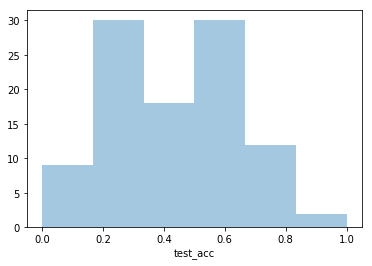

In [68]:
print(summary['test_acc'].max())

a = summary[summary.train_acc == 1]
print(len(a))
print(a['test_acc'].mean())

b = summary[(summary.train_acc > 0.6) & (summary.train_acc < 1)]
print(len(b))
print(b['test_acc'].mean())

c = summary[(summary.train_acc <= 0.6)]
print(len(c))
print(c['test_acc'].mean())

sns.distplot(summary.test_acc,kde = False)


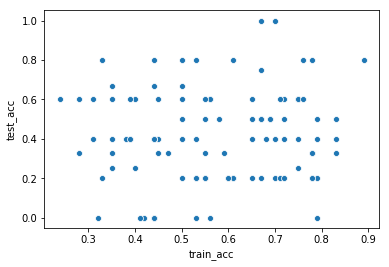

In [13]:
sns.scatterplot(summary.train_acc,summary.test_acc)

In [65]:
cat_predict_outcome = []
for i in summary['predict outcome']:
    cat_predict_outcome.extend(i)
cat_actual_outcome = []
for i in summary['actual outcome']:
    cat_actual_outcome.extend(i)
hi = list(zip(cat_predict_outcome, cat_actual_outcome))
date = df.index[-len(cat_predict_outcome):]

the_outcome = pd.DataFrame(hi , index = date, columns = ['predict_outcome','actual_outcome'])
the_outcome['compare'] = the_outcome.predict_outcome - the_outcome.actual_outcome
the_outcome['DoW'] = the_outcome.index.map(lambda x: x.weekday())


In [64]:
correct = the_outcome[the_outcome.compare == 0]
dead_wrong = the_outcome[abs(the_outcome.compare) == 2]

print (f'Acc: {len(correct)/ len(the_outcome)} _ {len(dead_wrong)/ len(the_outcome)}')

predict0 = the_outcome[the_outcome.predict_outcome == 0]
correct0 = predict0[the_outcome.actual_outcome == 0]
dead_wrong0 = predict0[the_outcome.actual_outcome == 2]
print (f'0_precision: {len(correct0)/len(predict0)}_{len(dead_wrong0)/len(predict0)}')
predict2 = the_outcome[the_outcome.predict_outcome == 2]
correct2 = predict2[the_outcome.actual_outcome == 2]
dead_wrong2 = predict2[the_outcome.actual_outcome == 0]
print (f'2_precision: {len(correct2)/len(predict2)}_{len(dead_wrong2)/len(predict2)}')

print(f'predict0: {len(predict0)/len(the_outcome)} _ predict2: {len(predict2)/len(the_outcome)}')
print(f'actual0: {len(the_outcome[the_outcome.actual_outcome == 0])/len(the_outcome)}_ actual2: {len(the_outcome[the_outcome.actual_outcome == 2])/len(the_outcome)}')

Acc: 0.42637362637362636 _ 0.33186813186813185
0_precision: 0.41543026706231456_0.33827893175074186
2_precision: 0.49504950495049505_0.36633663366336633
predict0: 0.7406593406593407 _ predict2: 0.22197802197802197
actual0: 0.4_ actual2: 0.378021978021978


In [66]:
print(f'according to DoW')
for i in range(5):
    i_days = the_outcome[the_outcome.DoW == i]
    correct = i_days[i_days.compare == 0]
    dead_wrong = i_days[abs(i_days.compare) == 2]
    print(f'{len(correct)/ len(i_days)} _ {len(dead_wrong)/ len(i_days)}')


according to DoW
0.38372093023255816 _ 0.3372093023255814
0.4943820224719101 _ 0.30337078651685395
0.45652173913043476 _ 0.31521739130434784
0.45161290322580644 _ 0.3225806451612903
0.3473684210526316 _ 0.37894736842105264


In [15]:
0.3880597014925373 _ 0.34328358208955223
0.5223880597014925 _ 0.2537313432835821
0.47761194029850745 _ 0.31343283582089554
0.43283582089552236 _ 0.31343283582089554
0.3880597014925373 _ 0.34328358208955223

### the following is backtesting the strategy

In [16]:
predict_array = []
for i in summary['predict outcome']:
    predict_array.extend(i)

date = df.index[-len(predict_array):]

strategy = pd.DataFrame(predict_array, columns = ['predict_outcome'], index = date)

strategy['DoW'] = strategy.index.map(lambda x: x.weekday())

strat_entry_price = []
strat_exit_price = []
for i in list(strategy.index):
    strat_entry_price.append(candles[(candles.date == i) & (candles.time == dt.time(9,45))].open.values[0])
    strat_exit_price.append(candles[(candles.date == i) & (candles.time == dt.time(16,25))].close.values[0])


strategy['entry_price'] = strat_entry_price
strategy['closing_price'] = strat_exit_price




In [17]:
from IPython.display import display, HTML

strategy['p_l'] = (strategy['closing_price'] - strategy['entry_price']) * -(strategy['predict_outcome'] - 1)
display(strategy)


print(f'p_l = {strategy.p_l.sum()}')
print('\n')
print(f'stats with 1')
print(f'PP: {len(strategy[strategy.p_l > 0])/len(strategy)}')
print(f'Avg: {strategy.p_l.mean()}')
print(f'SD: {strategy.p_l.std(ddof = 0)}')
print(f'SR: {strategy.p_l.mean()/strategy.p_l.std(ddof = 0)}')

strategy_wo1 = strategy[strategy.predict_outcome != 1]

print('\n')
print(f'stats without 1')
print(f'PP: {len(strategy_wo1[strategy_wo1.p_l > 0])/len(strategy_wo1)}')
print(f'Avg: {strategy_wo1.p_l.mean()}')
print(f'SD: {strategy_wo1.p_l.std(ddof = 0)}')
print(f'SR: {strategy_wo1.p_l.mean()/strategy_wo1.p_l.std(ddof = 0)}')


for i in range(5):
    hihi = strategy_wo1[strategy_wo1.DoW == i]
    print('\n')
    print(f'Only for day of week {i+1}: {len(hihi)}')
    print(f'PP: {len(hihi[hihi.p_l > 0])/len(hihi)}')
    print(f'Avg: {hihi.p_l.mean()}')
    print(f'SD: {hihi.p_l.std(ddof = 0)}')
    print(f'SR: {hihi.p_l.mean()/hihi.p_l.std(ddof = 0)}')


,predict_outcome,DoW,entry_price,closing_price,p_l
2016-11-28,0.0,0,22832.0,22800.0,-32.0
2016-11-29,0.0,1,22820.0,22804.0,-16.0
2016-11-30,0.0,2,22863.0,22822.0,-41.0
2016-12-01,0.0,3,22902.0,22894.0,-8.0
2016-12-02,0.0,4,22733.0,22575.0,-158.0
2016-12-05,0.0,0,22561.0,22580.0,19.0
2016-12-06,0.0,1,22725.0,22705.0,-20.0
2016-12-07,0.0,2,22799.0,22794.0,-5.0
2016-12-08,0.0,3,23031.0,22831.0,-200.0
2016-12-09,0.0,4,22790.0,22744.0,-46.0


p_l = 5117.0


stats with 1
PP: 0.5032967032967033
Avg: 11.246153846153845
SD: 192.83861287894402
SR: 0.05831899368210924


stats without 1
PP: 0.5228310502283106
Avg: 11.682648401826484
SD: 196.53231744265028
SR: 0.059443904971178976


Only for day of week 1: 84
PP: 0.5238095238095238
Avg: 7.523809523809524
SD: 174.93695981494895
SR: 0.04300869028345026


Only for day of week 2: 85
PP: 0.6
Avg: 30.741176470588236
SD: 210.2601835229069
SR: 0.1462054106275386


Only for day of week 3: 90
PP: 0.5444444444444444
Avg: 13.811111111111112
SD: 240.22858995568936
SR: 0.057491538012434736


Only for day of week 4: 88
PP: 0.4772727272727273
Avg: 7.693181818181818
SD: 184.98337504873646
SR: 0.04158850391909512


Only for day of week 5: 91
PP: 0.4725274725274725
Avg: -0.5274725274725275
SD: 160.2349470504148
SR: -0.0032918694528389523
